In [11]:
import torch
print(torch.__version__)

2.4.0+cu121


## build components

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertModel, BertTokenizer, AdamW
from torch.utils.data import Dataset

class BertBinaryClassifier(nn.Module):
    def __init__(self, bert_path_or_name, num_labels=2):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_path_or_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
        # 冻结 BERT 的所有参数
        for param in self.bert.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # 获取 BERT 的输出
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # 使用 [CLS] token 的输出
        cls_output = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_size)
        # 通过分类头
        logits = self.classifier(cls_output)  # (batch_size, num_labels)
        return logits


class CLSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        """
        初始化数据集
        Args:
            texts (list): 包含文本的列表
            labels (list): 文本对应的标签列表
            tokenizer (PreTrainedTokenizer): 分词器实例
            max_length (int): 文本最大长度，超过此长度将会截断
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        """
        获取数据样本，并将文本转为 BERT 可用的输入格式
        Args:
            idx (int): 索引值
        Returns:
            dict: 包含 `input_ids`, `attention_mask`, `labels` 的字典
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # 对文本进行编码
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # 获取编码结果并移除不必要的维度
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


def train(model, data_loader, criterion, optimizer, device):
    """训练模型并返回平均训练损失"""
    model.train()  # 将模型设置为训练模式
    total_loss = 0.0  # 初始化总训练损失
    total_correct = 0  # 初始化正确预测的数量 

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 前向传播和计算损失
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累加当前 batch 的总损失
        total_loss += loss.item() * input_ids.size(0)

         # 计算预测正确的样本数量
        _, predicted = torch.max(logits, dim=1)  # 取 logits 中的最大值作为预测类别
        total_correct += (predicted == labels).sum().item()  # 统计正确预测数量

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy

def eval(model, data_loader, criterion, device):
    """评估模型并返回平均验证损失"""
    model.eval()  # 将模型设置为评估模式
    total_loss = 0.0
    total_correct = 0  # 初始化正确预测的数量

    with torch.no_grad():  # 禁用梯度计算
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # 前向传播计算验证损失
            logits = model(input_ids, attention_mask)
            val_loss = criterion(logits, labels)

            # 累加当前 batch 的总验证损失
            total_loss += val_loss.item() * input_ids.size(0)

            # 计算预测正确的样本数量
            _, predicted = torch.max(logits, dim=1)
            total_correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)

    return avg_loss, accuracy

## load model

In [13]:
model_path = "../models/FinBert"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertBinaryClassifier(model_path)

## load data

In [14]:
import pandas as pd
import os
import subprocess
from torch.utils.data import DataLoader, random_split

data_name = "Dataset-of-financial-news-sentiment-classification"

if not os.path.exists(f"../data/cleaned/{data_name}.jsonl"):
    print("处理原始数据...")
    assert os.path.exists(f"../data/raw/{data_name}"), "尚未从github上clone原始数据"
    train_data = pd.read_csv(f"../data/raw/{data_name}/train_data.csv")
    test_data = pd.read_csv(f"../data/raw/{data_name}/test_data.csv")
    get_text = lambda x: x['正文']
    get_label = lambda x: x['正负面']
    # 合并数据集
    df = pd.concat([
        train_data.assign(split='train', text=get_text, label=get_label),
        test_data.assign(split='test', text=get_text, label=get_label)
    ], ignore_index=True)[['split', 'text', 'label']]
    # 清洗
    df = df[df['text'].notna() & (df['text'] != '')]
    # 保存清洗后的数据
    df.to_json(f'../data/cleaned/{data_name}.jsonl', index=False, orient='records',force_ascii=False, lines=True)

df = pd.read_json(f"../data/cleaned/{data_name}.jsonl", lines=True)
train_df = df.query("split == 'train'")
train_ds = CLSDataset(
    tokenizer = tokenizer,
    texts = train_df['text'].to_list(),
    labels = train_df['label'].to_list(),
    max_length = 512,
)

train_size = int(0.7 * len(train_ds))  # 70% 的训练数据
val_size = len(train_ds) - train_size   # 剩余的 30% 作为验证数据
train_subset, val_subset = random_split(train_ds, [train_size, val_size]) 

batch_size = 16  # 设置批量大小
train_dl = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [15]:
print(df.loc[0,'text'])
print(tokenizer.decode(train_ds[0]['input_ids'].tolist()))

盛运环保2月13日晚间发布公告称，截至目前，共有37.48亿元到期债务未清偿。
[CLS] 盛 运 环 保 2 月 13 日 晚 间 发 布 公 告 称 ， 截 至 目 前 ， 共 有 37. 48 亿 元 到 期 债 务 未 清 偿 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

## train setting

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.classifier.parameters(), lr=2e-5)  # 只更新分类头的参数
criterion = nn.CrossEntropyLoss()
num_epochs = 50

/mnt/disk1/JXH/01_apps/miniforge3/envs/finbot/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## run

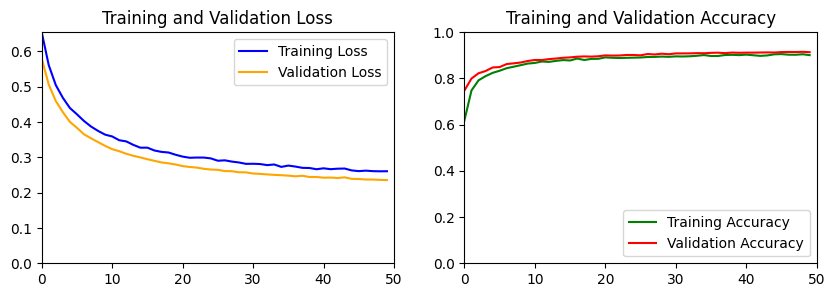

Epoch [50/50], Average Training Loss: 0.2605, Training Accuracy: 0.9011, Average Validation Loss: 0.2355, Validation Accuracy: 0.9139


In [7]:
## 开启训练
import matplotlib.pyplot as plt
from IPython import display
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
plt.figure(dpi=500)  # 设置图形的 DPI (每英寸点数)

# 训练和评估模型
train_losses = []  # 用于存储每个 epoch 的训练平均 loss
val_losses = []    # 用于存储每个 epoch 的验证平均 loss
train_accuracies = []  # 用于存储每个 epoch 的训练精确度
val_accuracies = []    # 用于存储每个 epoch 的验证精确度

# plt.ion()  # 开启交互模式

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(model, train_dl, criterion, optimizer, device)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    avg_val_loss, val_accuracy = eval(model, val_dl, criterion, device)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    display.clear_output(wait=True)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,3))
    fig.subplots_adjust(hspace=0.3)  # 调整子图间隔
    # 更新损失图
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='orange')
    ax1.set_xlim(0, epoch + 1)  # 动态调整 x 轴
    ax1.set_ylim(0, max(max(train_losses), max(val_losses, default=0), 1e-10))  # 动态调整 y 轴
    ax1.legend(loc='upper right')
    ax1.set_title('Training and Validation Loss')

    # 更新准确度图
    ax2.plot(train_accuracies, label='Training Accuracy', color='green')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_xlim(0, epoch + 1)  # 动态调整 x 轴
    ax2.set_ylim(0, 1)  # 精确度范围在 [0, 1]
    ax2.legend(loc='lower right')
    ax2.set_title('Training and Validation Accuracy')
    
    plt.pause(1e-9)  # 暂停以更新图形

    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Average Training Loss: {avg_train_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.4f}, "
          f"Average Validation Loss: {avg_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.4f}")
    

## save model

In [8]:
import json
import os
# 指定保存路径
save_dir = '../models/trained/finbert_ckpts'  # 替换为你的保存路径
os.makedirs(save_dir, exist_ok=True)

# 保存模型权重
model_path = os.path.join(save_dir, 'model_weights.pth')
torch.save(model.state_dict(), model_path)
print(f"Model weights saved to {model_path}")

# 保存训练指标
metrics = {
    'base': 'finbert',
    'epochs': list(range(1, num_epochs + 1)),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

metrics_json_path = os.path.join(save_dir, 'training_metrics.json')
with open(metrics_json_path, 'w') as json_file:
    json.dump(metrics, json_file, ensure_ascii=True)
print(f"Training metrics saved to {metrics_json_path}")

Model weights saved to ../models/trained/finbert_ckpts/model_weights.pth
Training metrics saved to ../models/trained/finbert_ckpts/training_metrics.json
